In [2]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
import seaborn as sns


from src.SlovotvirModel import (run_model_parallel)
from src.helpers import (letter_subplots, 
                         binning,
                         gini)

sns.set(context='paper', 
        style='ticks', 
        font_scale=1,
        rc={'axes.spines.right': False, 
            'axes.spines.top': False,})

sns.set_palette('colorblind')

### 1. Model demonstration

In [2]:
N = 100

In [25]:
neutral = run_model_parallel([0] * N, [1] * N, [1] * N, N)
length_bias_s = run_model_parallel([-5] * N, [1] * N, [1] * N, N)
like_bias = run_model_parallel([0] * N, [2] * N, [1] * N, N)

In [27]:
binned_lb = [binning([x for x in i[1]]) for i in like_bias]
binned_ls = [binning([x for x in i[1]]) for i in length_bias_s]
# binned_lw = [binning([x * y for x, y in i[1]]) for i in length_bias_w]
binned_n = [binning([x for x in i[1]]) for i in neutral]
# binned_lbr = [binning([x * y for x, y in i[1]]) for i in length_bias_r]

### 1. BayesFlow input

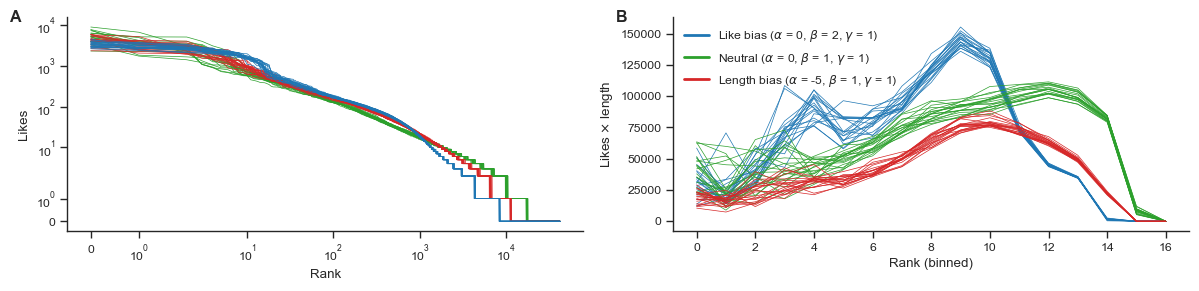

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
letter_subplots(axs)
alpha = 1

# First plot
for i in neutral:
    axs[0].plot(range(len(i[0])), i[0], color='tab:green', 
                alpha=alpha, 
                label='Neutral', 
                linewidth=0.5)
for i in length_bias_s:
    axs[0].plot(range(len(i[0])), i[0], color='tab:red',
                 alpha=alpha, 
                 label='Length bias', 
                 linewidth=0.5)
for i in like_bias:
    axs[0].plot(range(len(i[0])), i[0], color='tab:blue', 
                alpha=alpha, 
                label='Like bias', 
                linewidth=0.5)
axs[0].set_xscale('symlog', base=10)
axs[0].set_yscale('symlog', base=10)
axs[0].set_xlabel('Rank')
axs[0].set_ylabel('Likes')

# Second plot
for i in binned_lb:
    axs[1].plot(range(len(i)), i, color='tab:blue', 
                alpha=alpha, 
                label=r'Like bias ($\alpha$ = 0, $\beta$ = 2, $\gamma$ = 1)', 
                linewidth=0.5)
for i in binned_n:
    axs[1].plot(range(len(i)), i, color='tab:green', 
                alpha=alpha, 
                label=r'Neutral ($\alpha$ = 0, $\beta$ = 1, $\gamma$ = 1)', 
                linewidth=0.5)
for i in binned_ls:
    axs[1].plot(range(len(i)), i, color='tab:red', 
                alpha=alpha, 
                label=r'Length bias ($\alpha$ = -5, $\beta$ = 1, $\gamma$ = 1)', 
                linewidth=0.5)

axs[1].set_xlabel('Rank (binned)')
axs[1].set_ylabel(r'Likes $\times$ length')
handles, labels = axs[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = axs[1].legend(by_label.values(), by_label.keys(), frameon=False)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    lh.set_linewidth(2)
# axs[1].set_title('Expected length -- rank distribution (
# binned)', fontsize=10, fontweight='bold', loc='left')

# sns.despine()
plt.tight_layout()
plt.show()

### 2. Interaction between alpha and beta

In [41]:
N = 20

alpha = np.linspace(-5, 5, N) # length
beta = np.linspace(-5, 5, N) # frequency

In [42]:
gini_m = np.zeros((N, N))
len_m = np.zeros((N, N))

for i in trange(N):
    for j in range(N):
        run = run_model_parallel([alpha[i]] * 1, [beta[j]] * 1, [1] * 1, 1)
        gini_m[i, j] = gini(run[0][0])
        # len_m[i, j] = np.mean([i * j for i, j in run[0][1]])
        len_m[i, j] = sum(run[0][1]) / sum(run[0][0])

  0%|          | 0/20 [00:00<?, ?it/s]

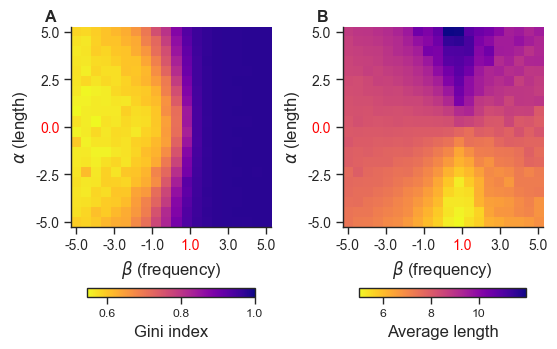

In [59]:
# only plot the gini index (alpha and beta) and mean length (alpha and beta)

fig, axes = plt.subplots(1, 2, figsize=(6.2, 4))

letter_subplots(axes, yoffset=1.05)

# Plot 1: gini_m
im1 = axes[0].imshow(gini_m, cmap='plasma_r', 
                     interpolation='none', vmax=1)
axes[0].invert_yaxis()
axes[0].set_xlabel(r'$\beta$ (frequency)', fontsize=12)
axes[0].set_ylabel(r'$\alpha$ (length)', fontsize=12)
axes[0].set_xticks(np.linspace(0, N - 1, 6))
axes[0].set_xticklabels(np.round(np.linspace(-5, 5, 6), 2))
axes[0].xaxis.get_ticklabels()[3].set_color('red')
axes[0].set_yticks(np.linspace(0, N - 1, 5))
axes[0].set_yticklabels(np.round(np.linspace(-5, 5, 5), 2))
axes[0].yaxis.get_ticklabels()[2].set_color('red')
cbar1 = fig.colorbar(im1, ax=axes[0], location='bottom', 
                     shrink=0.8, pad=0.2)
cbar1.set_label('Gini index', fontsize=12)

# Plot 2: len_m
im4 = axes[1].imshow(len_m, cmap='plasma_r', interpolation='none',
                     vmax=max(len_m.flatten()))
axes[1].invert_yaxis()
axes[1].set_xlabel(r'$\beta$ (frequency)', fontsize=12)
axes[1].set_ylabel(r'$\alpha$ (length)', fontsize=12)
axes[1].set_xticks(np.linspace(0, N - 1, 6))
axes[1].set_xticklabels(np.round(np.linspace(-5, 5, 6), 2))
# color 1 ticks in red on x-axis
axes[1].xaxis.get_ticklabels()[3].set_color('red')
axes[1].set_yticks(np.linspace(0, N - 1, 5))
axes[1].set_yticklabels(np.round(np.linspace(-5, 5, 5), 2))
# color 0 ticks in red on y-axis
axes[1].yaxis.get_ticklabels()[2].set_color('red')
cbar2 = fig.colorbar(im4, ax=axes[1], location='bottom', 
                     shrink=0.8, pad=0.2)
cbar2.set_label('Average length', fontsize=12)

# increase font size in the plot
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)

# add a title on top of the figure
# fig.suptitle(r'$\tau$ = 1', 
#              fontsize=12, fontweight='bold',
#              x=0.1,
#              y=0.94)
# reduce gap between subplots
plt.subplots_adjust(wspace=0.3)

# reduce image size by rasterizing
for ax in axes:
    ax.get_images()[0].set_rasterized(True)

plt.savefig('../figures/Figure_3.pdf',
            dpi=300, 
            bbox_inches='tight',)
# plt.tight_layout()
plt.show()

### 3. Binning 

In [3]:
fake_dist = run_model_parallel([1], [5], [1], 1)[0]
fake_dist_bins = binning(fake_dist[0])

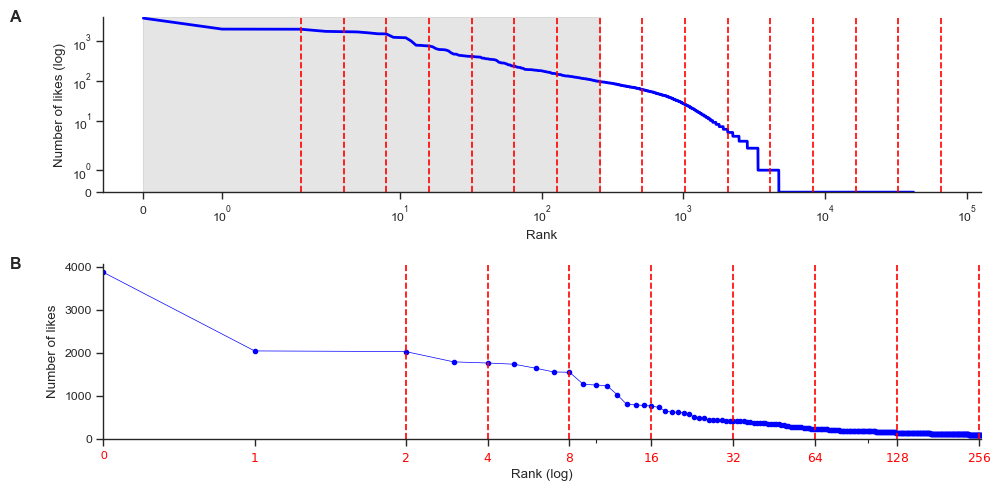

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
letter_subplots()

# First subplot
axes[0].plot(fake_dist[0], color='blue', linewidth=2, )
axes[0].grid(False)
# add vertical lines at powers of 2
for i in range(1, 17):
    axes[0].axvline(2 ** i, color="red", linestyle="--", alpha=1)
# plt.text(2 ** i - 1, 10^4, str(fake_dist_bins[i-1]), rotation=90)
axes[0].set_yscale("symlog", base=10)
axes[0].set_ylim(0, None)
axes[0].set_xscale("symlog", base=10)
# make a black square around the zone 0-200
axes[0].axvspan(0, 256, color='black', alpha=0.1)
axes[0].set_ylabel("Number of likes (log)")
axes[0].set_xlabel("Rank")

# Second subplot
axes[1].plot(fake_dist[0], color='blue', linewidth=0.5, marker='o', markersize=3)
axes[1].set_xlim(0, 2**8 + 4)
axes[1].grid(False)
axes[1].set_ylim(0, None)
axes[1].set_xscale("symlog")
for i in range(1, 9):
    axes[1].axvline(2 ** i, color="red", linestyle="--", alpha=1)
axes[1].set_xticks([0] + [2 ** i for i in range(9)])
axes[1].set_xticklabels([0] + [f'${2**i}$' for i in range(9)], color='red')
axes[1].set_ylabel("Number of likes")
axes[1].set_xlabel("Rank (log)")

sns.despine()
plt.tight_layout()

plt.savefig("../figures/Figure_s1.pdf", bbox_inches='tight')
plt.show()